# Применение машинного обучения: предсказание выручки магазина

Исследование на данных федеральной сети магазинов одежды. В нашем распоряжении файл с 336 магазинами, отработавшими полный 2015 год, и их признаками. Список признаков был составлен вручную исходя из представлений о том, какие признаки могут в наибольшей степени влиять на выручку магазина.

Задача: методом машинного обучения определить коэффициенты значимости признаков и  научиться предсказывать будущий оборот еще не открытого магазина по его признакам.

Прочитаем таблицу, обработаем данные, выберем способ, с помощью которой будем обучать алгоритм, проверим корректность работы модели.

### Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
pd.set_option('display.max_columns', None) #настраиваем вывод таблицы, чтобы видеть все столбцы

In [3]:
stores = pd.read_csv('coeffs_.csv', delimiter = ";")
stores.head()

,district,city,mall,city_population,number_in_city,mall_gla,store_gla,competitors,median_salary,mean_salary,mode_salary,live_minimum,other_malls,region,location_in_city,parking,grocery_store,cinema,foodcourt,format,sales
0,Дальневосточный федеральный округ,Хабаровск,SmileMart,611160,3,9000,233,14,29389,37677,17881,13417,5,1,3,1,1,0,0,0,3781466
1,Дальневосточный федеральный округ,Нерюнгри,Айгуль,57791,1,1300,321,1,28913,37857,16865,15140,1,1,1,1,0,1,0,1,2873792
2,Дальневосточный федеральный округ,Комсомольск-на-Амуре,БУМ,251283,1,7800,349,3,29389,37677,17881,13417,0,1,1,1,1,0,1,1,5240553
3,Дальневосточный федеральный округ,Петропавловск-Камчатский,Галант-Сити,180963,1,11900,351,9,31869,39494,20751,18020,1,1,1,1,0,0,1,1,5108767
4,Дальневосточный федеральный округ,Южно-Сахалинск,Поповича 100,193669,2,2280,307,0,36534,48853,20433,13672,1,1,1,1,0,0,0,2,3254806


In [4]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   district          336 non-null    object
 1   city              336 non-null    object
 2   mall              336 non-null    object
 3   city_population   336 non-null    int64 
 4   number_in_city    336 non-null    int64 
 5   mall_gla          336 non-null    int64 
 6   store_gla         336 non-null    int64 
 7   competitors       336 non-null    int64 
 8   median_salary     336 non-null    int64 
 9   mean_salary       336 non-null    int64 
 10  mode_salary       336 non-null    int64 
 11  live_minimum      336 non-null    int64 
 12  other_malls       336 non-null    int64 
 13  region            336 non-null    int64 
 14  location_in_city  336 non-null    int64 
 15  parking           336 non-null    int64 
 16  grocery_store     336 non-null    int64 
 17  cinema          

In [5]:
print('Количество явных дубликатов:', stores.duplicated().sum())
print('Количество неявных дубликатов:', stores[['city','mall']].duplicated().sum()) 

Количество явных дубликатов: 0
Количество неявных дубликатов: 0


Итак, в нашей таблие 336 строк (магазинов) и 21 столбец. В каждом столбце указан признак, относящийся к магазину:
   - `district` - федеральный округ
   - `city` - город
   - `mall` - название ТЦ
   - `city_population`- население города
   - `mall_gla` - арендопригодная площадь ТЦ
   - `store_gla` - арендопригодная площадь магазина
   - `competitors` - количество магазинов основных федеральных сетей одежды, обуви, косметики и детских товаров
   - `median_salary` - медианная зарплата в регионе
   - `mean_salary` - медианная зарплата в регионе
   - `mode_salary` - медианная зарплата в регионе
   - `live_minimum` - прожиточный минимум в регионе
   - `other_malls` - количество конкурентных ТЦ в радиусе нескольких километров  
   - `region` - условный номер региона
   - `location_in_city` - расположение: 1 - центр города либо прямо у метро, 2 - за чертой города, 3 - районные
   - `parking`- парковка в ТЦ: 1 - есть, 0 - нет
   - `grocery_store` - продуктовый магазин в ТЦ: 1 - есть, 0 - не
   - `cinema` - кинотеатр в ТЦ: 1 - есть, 0 - не 
   - `foodcourt` - фудкорт в ТЦ: 1 - есть, 0 - не 
   - `format` - формат: 1 - регулярный, 0 - дисконт, 2 - стрит
   - `sales` - средние продажи за полный год

Проверим как распределяются средние продажи за полный год.

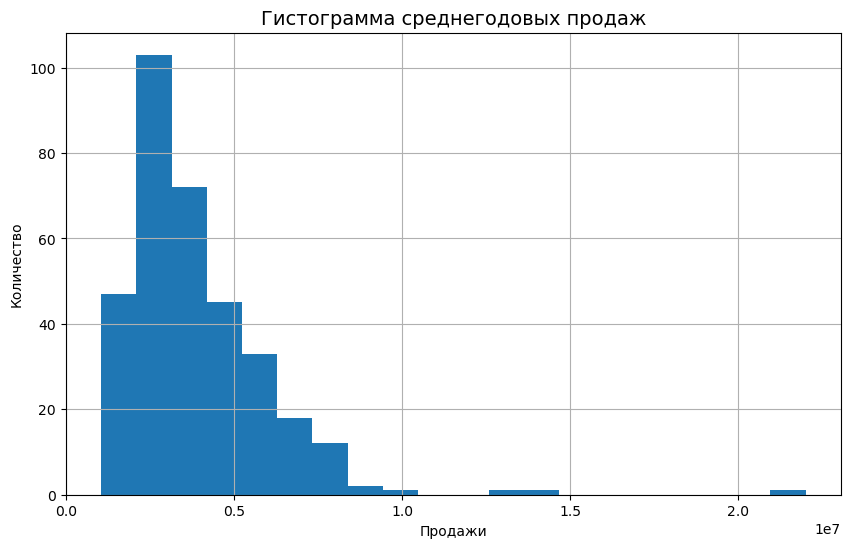

In [6]:
plt.figure(figsize=(10, 6))
stores['sales'].hist(bins = 20)
plt.title('Гистограмма среднегодовых продаж', fontsize=14)
plt.ylabel('Количество')
plt.xlabel('Продажи')
plt.show()

In [7]:
np.percentile(stores['sales'].dropna(), [1, 5, 95, 99])

array([1366097.        , 1749991.25      , 7423547.75      ,
       9652064.04999999])

Видим выбросы на графике. Посчитаем выбросами все магазины, которые делают больше 9 652 064 в месяц (лежат в 99% перцентиле). Посмотрим на них:

In [8]:
stores.loc[stores['sales'] >= 9652064]

,district,city,mall,city_population,number_in_city,mall_gla,store_gla,competitors,median_salary,mean_salary,mode_salary,live_minimum,other_malls,region,location_in_city,parking,grocery_store,cinema,foodcourt,format,sales
205,Уральский федеральный округ,Тюмень,Солнечный,720575,3,35000,442,13,29859,41117,15747,12751,3,10,3,1,1,0,1,1,9877925
333,Центральный федеральный округ,Москва,Ашан Марфино,12330126,26,30000,575,4,43043,59567,22475,14749,0,5,2,1,1,0,1,1,13747622
334,Центральный федеральный округ,Москва,Орджоникидзе,12330126,26,30000,813,10,43043,59567,22475,14749,1,5,3,1,0,0,1,0,22014454
335,Центральный федеральный округ,Москва,Речной,12330126,26,17000,472,4,43043,59567,22475,14749,2,5,1,1,1,0,1,1,12775538


Это экстраординарные магазины с очень высокими выручками. Удалим их из данных.

In [9]:
stores = stores.loc[stores['sales'] < 9652064]

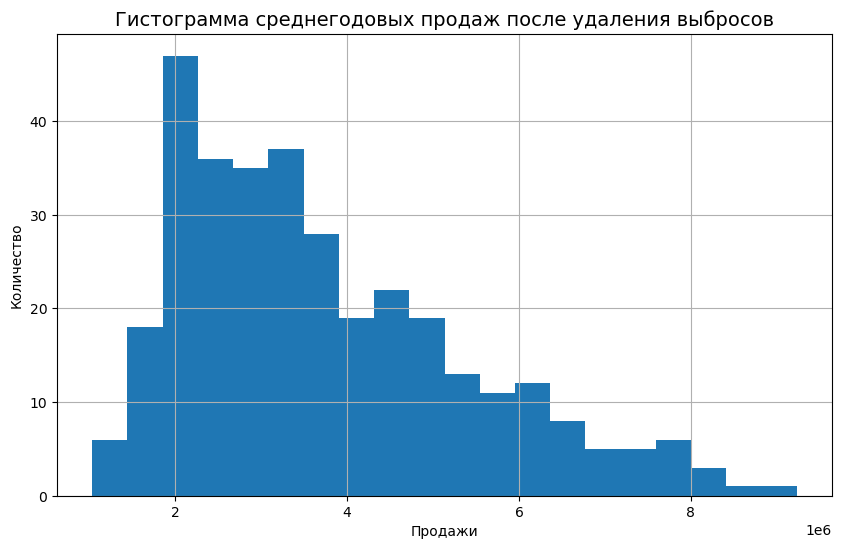

In [10]:
plt.figure(figsize=(10, 6))
stores['sales'].hist(bins = 20)
plt.title('Гистограмма среднегодовых продаж после удаления выбросов', fontsize=14)
plt.ylabel('Количество')
plt.xlabel('Продажи')
plt.show()

Посмотрим на диаграммы зависимостей sales от других критериев:

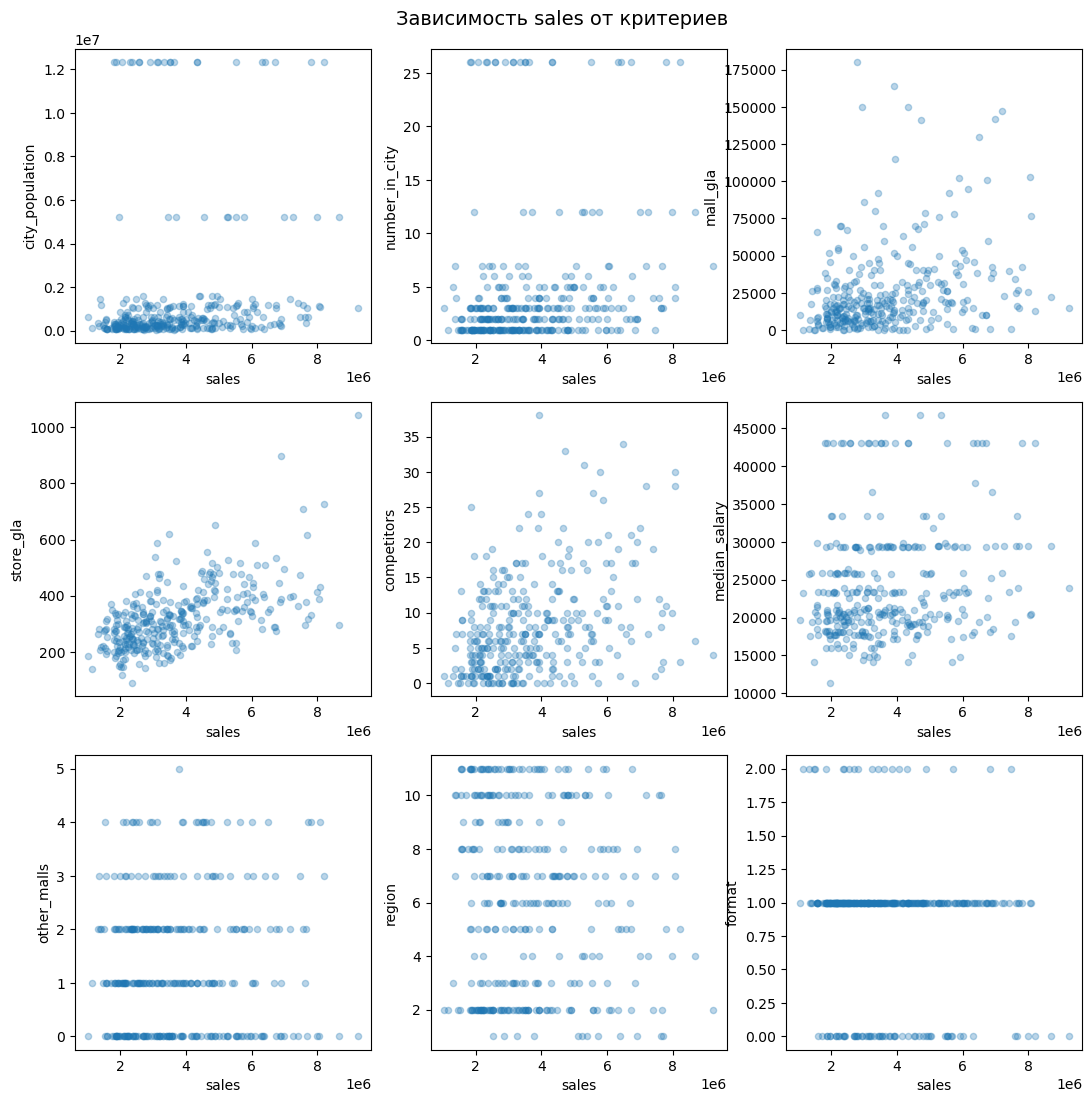

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(13, 13))

stores.plot.scatter(ax=axes[0,0], x='sales', y='city_population', alpha = 0.3)
stores.plot.scatter(ax=axes[0,1], x='sales', y='number_in_city', alpha = 0.3)
stores.plot.scatter(ax=axes[0,2], x='sales', y='mall_gla', alpha = 0.3)
stores.plot.scatter(ax=axes[1,0], x='sales', y='store_gla', alpha = 0.3)
stores.plot.scatter(ax=axes[1,1], x='sales', y='competitors', alpha = 0.3)
stores.plot.scatter(ax=axes[1,2], x='sales', y='median_salary', alpha = 0.3)
stores.plot.scatter(ax=axes[2,0], x='sales', y='other_malls', alpha = 0.3)
stores.plot.scatter(ax=axes[2,1], x='sales', y='region', alpha = 0.3)
stores.plot.scatter(ax=axes[2,2], x='sales', y='format', alpha = 0.3)

plt.suptitle('Зависимость sales от критериев', y=0.91, fontsize=14);

Явную зависимость можем отметить только у признака "store_gla". 

Построим матрицу корреляции, чтобы исключить лишние признаки, и построим хитмэп. Для этого оставим в таблице только числовые данные.

In [12]:
stores_n = stores.drop(['district', 'city', 'mall'], axis=1)

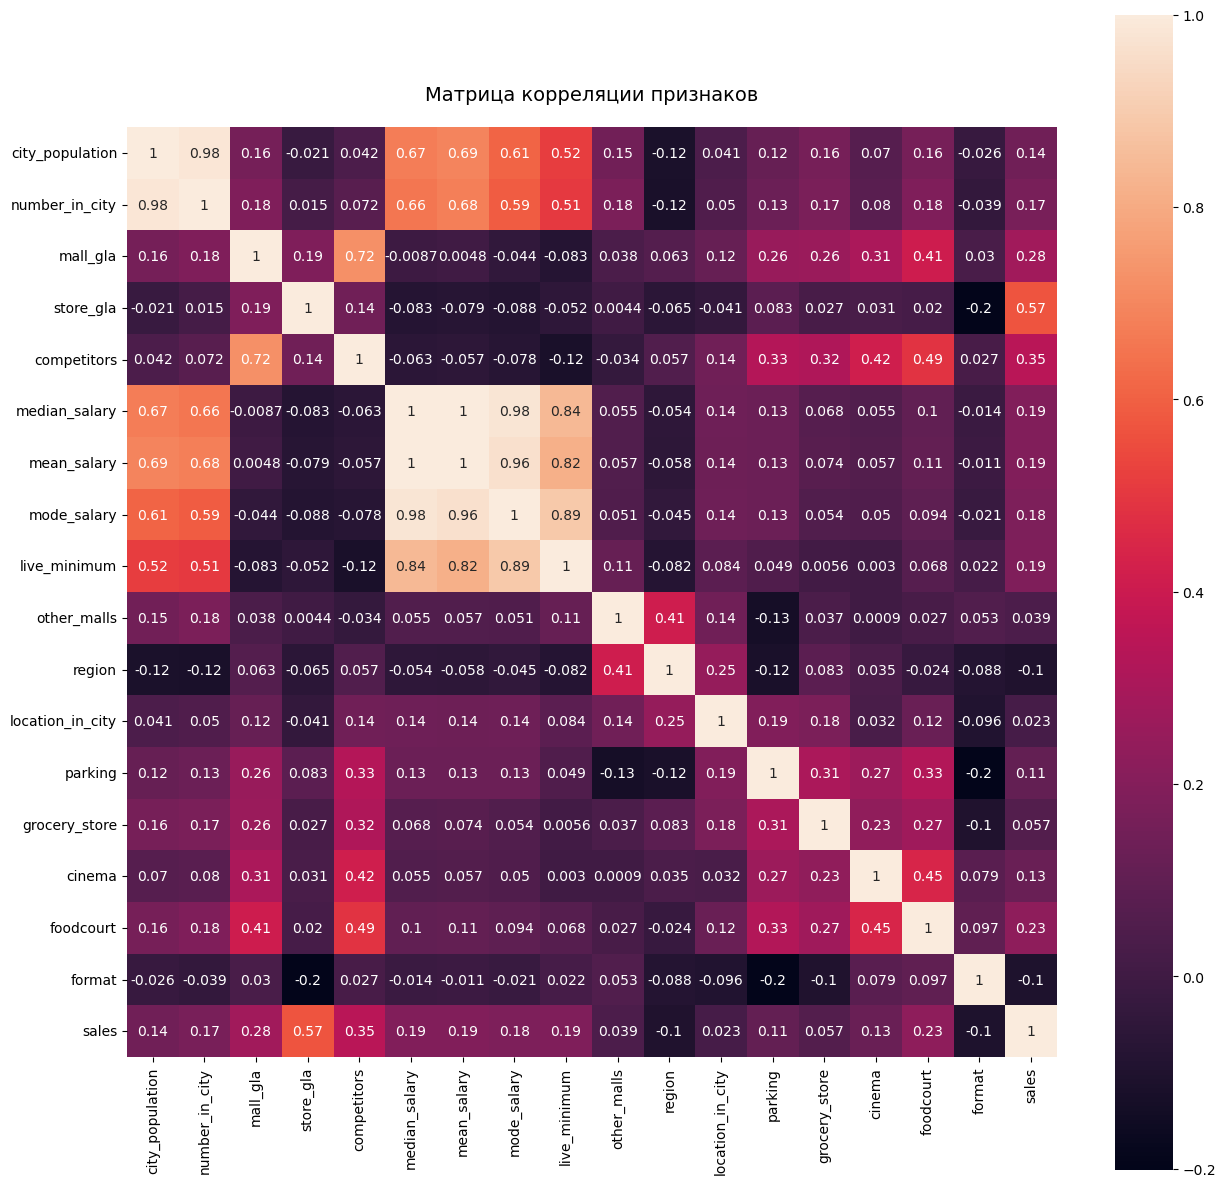

In [13]:
corr_m = stores_n.corr() # корреляционная матрица

plt.figure(figsize = (15,15)) # нарисуем heatmap
sns.heatmap(corr_m, square = True, annot = True)
plt.title('Матрица корреляции признаков',y=1.02, fontsize=14)
plt.show()

Видно, что некоторые признаки почти на 100% коррелируют между собой, поэтому уберем их. Сильно коррелирующие с другими признаки: "number_in_city", "mean_salary", "mode_salary".

In [14]:
stores_n = stores_n.drop(['number_in_city', 'mean_salary', 'mode_salary'], axis=1)

Далее поделим наши данные на 2 части: 90% на обучение и 10% на тест. Для теста возьмем каждый одиннадцатый магазин из отсортированному по выручке датафрейму.


In [15]:
stores_n = stores_n.sort_values(by = 'sales').reset_index(drop=True) #сортируем
stores_n

,city_population,mall_gla,store_gla,competitors,median_salary,live_minimum,other_malls,region,location_in_city,parking,grocery_store,cinema,foodcourt,format,sales
0,643496,10000,185,1,19697,8726,0,2,1,1,0,0,0,1,1035536
1,98763,139,139,0,23286,7695,1,2,1,0,0,0,0,2,1142985
2,351226,900,265,1,25816,13169,2,3,1,1,0,0,0,2,1316462
3,226776,6500,280,2,17519,9935,3,7,1,0,1,0,0,1,1356038
4,1444439,17200,206,5,25898,9602,2,10,1,0,0,0,1,1,1384778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,1119875,103000,390,28,20407,9386,0,8,2,1,1,0,1,1,8053149
328,1066934,76500,431,30,20514,10799,4,7,1,1,1,1,1,1,8073536
329,12330126,12500,728,3,43043,14749,3,5,1,1,1,0,0,0,8204713
330,5225690,22000,295,6,29504,9995,0,4,1,1,0,1,1,0,8675682


In [16]:
step = 11
rows = [i for i in range(11, len(stores_n), step)] #создаем список, содержащий значения от 11 до длины stores_т с шагом step

Создаем тестовый датафрейм.

In [17]:
test = stores_n.iloc[rows] 
test.head()

,city_population,mall_gla,store_gla,competitors,median_salary,live_minimum,other_malls,region,location_in_city,parking,grocery_store,cinema,foodcourt,format,sales
11,510020,26707,310,1,21411,8261,3,11,1,1,1,1,1,1,1560782
22,73324,5500,276,1,29368,10795,1,6,1,1,0,0,0,1,1845250
33,408025,52000,197,18,18177,9462,2,11,1,1,1,1,1,1,1940952
44,12330126,22000,116,2,43043,14749,1,5,3,1,1,1,1,1,2066544
55,236197,13000,288,5,23286,7695,0,2,1,1,1,1,1,1,2147710


Создаем тренировочный датафрейм.

In [18]:
train = stores_n.drop(rows)
train.head()

,city_population,mall_gla,store_gla,competitors,median_salary,live_minimum,other_malls,region,location_in_city,parking,grocery_store,cinema,foodcourt,format,sales
0,643496,10000,185,1,19697,8726,0,2,1,1,0,0,0,1,1035536
1,98763,139,139,0,23286,7695,1,2,1,0,0,0,0,2,1142985
2,351226,900,265,1,25816,13169,2,3,1,1,0,0,0,2,1316462
3,226776,6500,280,2,17519,9935,3,7,1,0,1,0,0,1,1356038
4,1444439,17200,206,5,25898,9602,2,10,1,0,0,0,1,1,1384778


### Машинное обучение (линейная регрессия, библиотека sklearn)

Преобразуем наши объекты DataFrame в массивы NumPy.

In [19]:
test_np = test.to_numpy() 
train_np = train.to_numpy()

Делим массивы test и train на матрицу признаков и вектор результатов.

In [20]:
X_test = test_np[:,:-1]
y_test = test_np[:,-1]

In [21]:
X_train = train_np[:,:-1]
y_train = train_np[:,-1]

Загружаем нужные библиотеки.

In [22]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

Создаем модель и обучаем ее.

In [23]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train);

Делаем предсказания на тестовом массиве.

In [24]:
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

Выводим график.

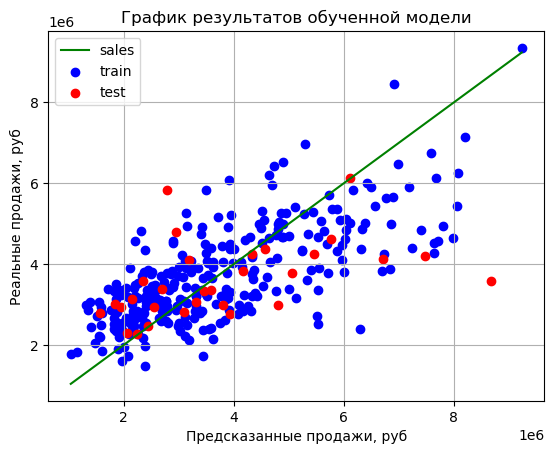

In [25]:
plt.plot(y_train, y_train, color="green", label = 'sales') #обе оси - значения из тренировочного сета y_train - зеленая линия
plt.scatter(y_train, y_pred_train, color="blue", label = 'train') 
plt.scatter(y_test, y_pred_test, color="red", label = 'test')
plt.title('График результатов обученной модели')
plt.grid()
plt.ylabel('Предсказанные продажи, руб')
plt.xlabel('Реальные продажи, руб')
plt.legend()
plt.show()

Как интерпретировать график: на зеленой линии лежат реальные выручки магазинов, синии точки - предсказания на данных тренировочного датасета, красные точки - предсказания тестового датафрейма, значения которых модель не видела ранее. 
Если точка лежит на линии, значит модель предсказала выручку точно. 

Если точка выше линии, значит модель сделала более оптимистичный прогноз, если ниже – более пессимистичный. Как видно, модель уловила тренд, что является хорошим результатом для такой небольшой базы данных, но выборка недостаточна, чтобы модель смогла обучиться давать более точный прогноз.

Посчитаем коэффициент детерминации, который принимает значения от 0 до 1 и показывает, насколько сделанный моделью прогноз отражает целевую переменную.

In [26]:
print("Коэффициент детерминации: %.2f" % r2_score(y_test, y_pred_test))

Коэффициент детерминации: 0.19


Выведем список получившихся коэффициентов, с помощью которых мы сможем предсказывать выручку будущих магазинов.

In [27]:
print("Coefficients: \n", regr.coef_)

Coefficients: 
 [-6.63965396e-02  3.75799769e+00  7.71539766e+03  6.63752296e+04
  5.34025544e+01  6.81175770e+01  9.89910669e+04 -5.82837899e+04
  5.16154759e+03 -4.13602490e+05 -1.08382379e+05 -9.52824629e+04
  3.42120829e+05 -1.48314959e+05]


In [28]:
coefs = pd.DataFrame({'features': ['city_population', 'mall_gla', 'store_gla', 'competitors', \
                                   'median_salary', 'live_minimum', 'other_malls', 'region', \
                                   'location_in_city','parking','grocery_store', 'cinema','foodcourt', 'format'],\
                      'coefs': regr.coef_.tolist()})
coefs

,features,coefs
0,city_population,-0.066397
1,mall_gla,3.757998
2,store_gla,7715.397657
3,competitors,66375.229580
4,median_salary,53.402554
5,live_minimum,68.117577
6,other_malls,98991.066919
7,region,-58283.789940
8,location_in_city,5161.547588
9,parking,-413602.490255


Мы получили список коэффициентов для признаков. На основе этого списка подготовлен excel-файл, с помощью которого можно предсказывать на основе модели выручку потенциального магазина, заполняя значения его критериев.

### Выводы

В рамках работы над нашей стратегией развития мы поставили интересную задачу по анализу данных работы магазинов. В условиях небольшого количества анализируемых данных была выбрана модель линейной регрессии. Результатом стало определение приблизительных коэффициентов для оценки будущей работы магазина. Однако данных недостаточно, чтобы основывать на этом прогнозе решение об открытии магазина.

План для улучшения прогноза модели:
1. Необходимо обновить данные следующими годами и обучить модель на них.
2. Добавить гео-данные: население в радиусе нескольких километров, наличие большого проездного трафика рядом (крупные шоссе). Эти данные возможно получить, используя API 2ГИС - набор инструментов для получения точных справочных и картографических данных 2ГИС.